## Reading Tabular Data

The Planetary Computer provides tabular data in the [Apache Parquet](https://parquet.apache.org/) file format, which provides a standardized high-performance columnar storage format.

When working from Python, there are several options for reading parquet datasets. The right choice depends on the size and kind of the data you're reading. When reading geospatial data, with one or more columns containing vector geometries, we recommend using [geopandas](https://geopandas.org/) for small datasets and [dask-geopandas](https://github.com/geopandas/dask-geopandas) for large datasets. For non-geospatial tabular data, we recommend [pandas](https://pandas.pydata.org/) for small datasets and [Dask](https://dask.org/) for large datasets.

Regardless of which library you're using to read the data, we recommend using [STAC](https://stacspec.org/) to discover which datasets are available, and which options should be provided when reading the data.

In this example we'll work with data from the US Forest Service's [Forest Inventory and Analysis](https://planetarycomputer.microsoft.com/dataset/fia) dataset. This includes a collection of tables providing information about forest health and location in the United States.

In [1]:
import pystac_client
import planetary_computer

catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
fia = catalog.get_collection("fia")
fia

id: fia
title: Forest Inventory and Analysis
"description: Status and trends on U.S. forest location, health, growth, mortality, and production, from the U.S. Forest Service's [Forest Inventory and Analysis](https://www.fia.fs.fed.us/) (FIA) program. The Forest Inventory and Analysis (FIA) dataset is a nationwide survey of the forest assets of the United States. The FIA research program has been in existence since 1928. FIA's primary objective is to determine the extent, condition, volume, growth, and use of trees on the nation's forest land. Domain: continental U.S., 1928-2018 Resolution: plot-level (irregular polygon) This dataset was curated and brought to Azure by [CarbonPlan](https://carbonplan.org/)."
"providers: Forest Inventory & Analysis (producer, licensor) CarbonPlan (processor) Microsoft (host)"
type: Collection
"item_assets: {'data': {'type': 'application/x-parquet', 'roles': ['data'], 'title': 'Dataset root', 'table:storage_options': {'account_name': 'cpdataeuwest'}}}"
msft:container: cpdata
msft:storage_account: cpdataeuwest
"msft:short_description: Status and trends on U.S. forest location, health, growth, mortality, and production, from the U.S. Forest Service's Forest Inventory and Analysis (FIA) program"
msft:region: westeurope
https://stac-extensions.github.io/item-assets/v1.0.0/schema.json


The FIA Collection has a number of items, each of which represents a different table stored in Parquet format.

In [2]:
list(fia.get_all_items())

[<Item id=tree_woodland_stems>,
 <Item id=tree_regional_biomass>,
 <Item id=tree_grm_midpt>,
 <Item id=tree_grm_estn>,
 <Item id=tree_grm_component>,
 <Item id=tree_grm_begin>,
 <Item id=tree>,
 <Item id=survey>,
 <Item id=subplot_regen>,
 <Item id=subplot>,
 <Item id=subp_cond_chng_mtrx>,
 <Item id=subp_cond>,
 <Item id=sitetree>,
 <Item id=seedling_regen>,
 <Item id=seedling>,
 <Item id=pop_stratum>,
 <Item id=pop_plot_stratum_assgn>,
 <Item id=pop_eval_typ>,
 <Item id=pop_eval_grp>,
 <Item id=pop_eval_attribute>,
 <Item id=pop_eval>,
 <Item id=pop_estn_unit>,
 <Item id=plotsnap>,
 <Item id=plot_regen>,
 <Item id=plotgeom>,
 <Item id=plot>,
 <Item id=p2veg_subp_structure>,
 <Item id=p2veg_subplot_spp>,
 <Item id=invasive_subplot_spp>,
 <Item id=dwm_visit>,
 <Item id=dwm_transect_segment>,
 <Item id=dwm_residual_pile>,
 <Item id=dwm_microplot_fuel>,
 <Item id=dwm_fine_woody_debris>,
 <Item id=dwm_duff_litter_fuel>,
 <Item id=dwm_coarse_woody_debris>,
 <Item id=county>,
 <Item id=cond_

To load a single table, get it's item and extract the `href` from the `data` asset. The "boundary" table, which provides information about subplots, is relatively small and doesn't contain a geospatial geometry column, so it can be read with pandas.

In [3]:
import pandas as pd
import planetary_computer

boundary = fia.get_item(id="boundary")
asset = boundary.assets["data"]

df = pd.read_parquet(
    asset.href,
    storage_options=asset.extra_fields["table:storage_options"],
    columns=["CN", "AZMLEFT", "AZMCORN"],
)
df.head()

,CN,AZMLEFT,AZMCORN
__null_dask_index__,,,
0,204719190010854,259,0
1,204719188010854,33,0
2,204719189010854,52,0
3,204719192010854,322,0
4,204719191010854,325,0


There are a few imporant pieces to highlight

1. As usual with the Planetary Computer, we signed the STAC item so that we could access the data. See [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.
2. We relied on the asset to provide all the information necessary to load the data like the `href` and the `storage_options`. All we needed to know was the ID of the Collection and Item
3. We used pandas' and parquet's ability to select subsets of the data with the `columns` keyword.

Larger datasets can be read using [Dask](https://dask.org/). For example, the `cpdata/raw/fia/tree.parquet` folder contains about 160 individual Parquet files, totalling about 22 million rows. In this case, pass the path to the directory to `dask.dataframe.read_parquet`.

In [4]:
import dask.dataframe as dd

tree = fia.get_item(id="tree")
asset = tree.assets["data"]

df = dd.read_parquet(
    asset.href,
    storage_options=asset.extra_fields["table:storage_options"],
    columns=["SPCD", "CARBON_BG", "CARBON_AG"],
    engine="pyarrow",
)
df

,SPCD,CARBON_BG,CARBON_AG
npartitions=160,,,
,int64,float64,float64
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


That lazily loads the data into a Dask DataFrame. We can operate on the DataFrame with pandas-like methods, and call `.compute()` to get the result. In this case, we'll compute the average amount of carbon sequestered above and below ground for each tree, grouped by species type. To cut down on execution time we'll select just the first partition.

In [5]:
result = df.get_partition(0).groupby("SPCD").mean().compute()  # group by species
result

,CARBON_BG,CARBON_AG
SPCD,,
43,37.864937,165.753430
67,3.549734,14.679764
68,9.071253,39.108406
107,19.321549,84.096184
110,29.964395,130.956288
...,...,...
973,4.632913,22.658887
975,38.988846,202.220124
976,25.385733,130.583668


### Geospatial parquet datasets

The `us-census` collection has some items that include a `geometry` column, and so can be loaded with `geopandas`. All parquet datasets hosted by the Planetary Computer with one or more geospatial columns use the [geoparquet](https://github.com/opengeospatial/geoparquet) standard for encoding the geospatial metadata.

In [6]:
import geopandas

item = catalog.get_collection("us-census").get_item("2020-cb_2020_us_state_500k")

asset = item.assets["data"]
df = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
df.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,66,1802705,0400000US66,66,GU,Guam,00,543555847,934337453,"MULTIPOLYGON (((144.64538 13.23627, 144.64716 ..."
1,48,1779801,0400000US48,48,TX,Texas,00,676680588914,18979352230,"MULTIPOLYGON (((-94.71830 29.72885, -94.71721 ..."
2,55,1779806,0400000US55,55,WI,Wisconsin,00,140292246684,29343721650,"MULTIPOLYGON (((-86.95617 45.35549, -86.95463 ..."
3,44,1219835,0400000US44,44,RI,Rhode Island,00,2677759219,1323691129,"MULTIPOLYGON (((-71.28802 41.64558, -71.28647 ..."
4,36,1779796,0400000US36,36,NY,New York,00,122049520861,19256750161,"MULTIPOLYGON (((-72.03683 41.24984, -72.03496 ..."


With this, we can visualize the boundaries for the continental United States.

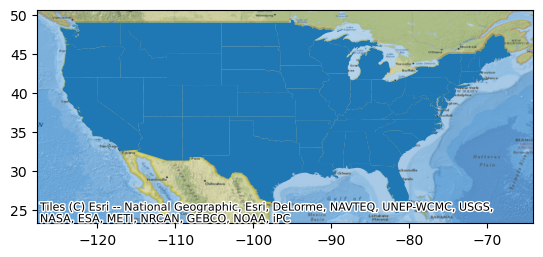

In [7]:
import contextily

drop = ["GU", "AK", "MP", "HI", "VI", "PR", "AS"]
ax = df[~df.STUSPS.isin(drop)].plot()
contextily.add_basemap(
    ax, crs=df.crs.to_string(), source=contextily.providers.Esri.NatGeoWorldMap
)

### Learn more

This quickstart briefly introduced how to access tabular data on the Planetary Computer. For more, see

* The [pandas documentation](https://pandas.pydata.org/docs/user_guide/io.html#parquet) for an introduction to Parquet
* [Scale with Dask](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/) for more on using Dask to work with large datasets in parallel
* The [Forest Inventory and Analysis](https://planetarycomputer.microsoft.com/dataset/fia) catalog page.